In [63]:
import gym
import gym.wrappers
import numpy as np
import logging
import matplotlib.pylab as pl
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [70]:
max_steps = 10000
gym.logger.setLevel(logging.ERROR)
env = gym.make("MountainCar-v0")
if isinstance(env, gym.wrappers.TimeLimit):
    env._max_episode_steps = max_steps
env = gym.wrappers.Monitor(env, "mountaincar-res")

n_actions = env.action_space.n

print("n_actions=%i" % (n_actions))

n_actions=3


In [71]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(40,40),
                      activation='relu',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));

/home/shmuma/sfw/anaconda/envs/pract_rl/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [72]:
def generate_session(t_max=max_steps+1):
    states, actions = [], []
    total_reward = 0
    s = env.reset()
    
    for _ in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        new_s, r, done, _ = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
            
    return states, actions, total_reward

In [75]:
n_samples = 250
percentile = 40
rewards = []
thresholds = []
finetune_mode = False

In [76]:
for i in range(500):
    #%time 
    sessions = [generate_session() for _ in range(n_samples)]
    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))
    
    threshold = np.percentile(batch_rewards, percentile)
    elite_states = batch_states[batch_rewards > threshold]
    elite_actions = batch_actions[batch_rewards > threshold]
    
    if not elite_states.size:
        print("%d: no elite sessions, try again" % i)
        continue
    
    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])
    
    agent.fit(elite_states, elite_actions)
    mean_reward = np.mean(batch_rewards)
    print("%d: mean reward = %.5f (max: %f)\tthreshold = %.1f" % (
        i, mean_reward, np.max(batch_rewards), threshold))
    thresholds.append(threshold)
    rewards.append(mean_reward)
    
    if mean_reward > -200:
        finetune_mode = True
        percentile = 25
        n_samples = 500
        print("Finetune mode!")







0: mean reward = -9989.96800 (max: -7492.000000)	threshold = -10000.0

1: no elite sessions, try again


2: no elite sessions, try again

3: no elite sessions, try again
4: mean reward = -9977.58400 (max: -4396.000000)	threshold = -10000.0
5: no elite sessions, try again
6: no elite sessions, try again

7: no elite sessions, try again
8: no elite sessions, try again
9: no elite sessions, try again
10: mean reward = -9971.64000 (max: -2910.000000)	threshold = -10000.0

11: no elite sessions, try again
12: no elite sessions, try again
13: no elite sessions, try again
14: no elite sessions, try again

15: no elite sessions, try again
16: no elite sessions, try again
17: mean reward = -9973.27600 (max: -3319.000000)	threshold = -10000.0
18: no elite sessions, try again

19: no elite sessions, try again
20: no elite sessions, try again
21: no elite sessions, try again
22: no elite sessions, try again

23: no elite sessions, try again
24: no elite sessions, try again
25: no elite sessi

KeyboardInterrupt: 

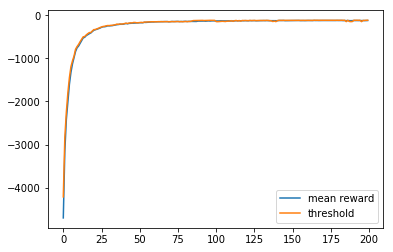

In [60]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()

In [61]:
env.close()